In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import sys
import time
from tqdm import tqdm

import scipy
import scipy.cluster.hierarchy as sch
from scipy import interp
from scipy.cluster.vq import vq,kmeans,whiten

#import sklearn.datasets as datasets
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.preprocessing import LabelBinarizer

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier

from itertools import cycle


from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Dropout

In [ ]:
df_classes = pd.read_csv("/content/elliptic_txs_classes.csv")
df_edges = pd.read_csv("/content/elliptic_txs_edgelist.csv")
df_features = pd.read_csv("/content/elliptic_txs_features.csv", header=None)

In [ ]:
colNames1 = {'0': 'txId', 1: "Time step"}
colNames2 = {str(ii+2): "Local_feature_" + str(ii+1) for ii in range(93)}
colNames3 = {str(ii+95): "Aggregate_feature_" + str(ii+1) for ii in range(72)}

colNames = dict(colNames1, **colNames2, **colNames3 )
colNames = {int(jj): item_kk for jj,item_kk in colNames.items()}

df_features = df_features.rename(columns=colNames)

In [ ]:
df_classes.loc[df_classes['class'] == 'unknown', 'class'] = 0
print('Shape of classes', df_classes.shape)
print('Shape of edges', df_edges.shape)
print('Shape of features', df_features.shape)

Shape of classes (203769, 2)
Shape of edges (234355, 2)
Shape of features (22622, 167)


In [ ]:
df_class_feature = pd.merge(df_classes, df_features )
df_class_feature.head()

,txId,class,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,...,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72
0,230425980,0,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,0,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,0,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,2,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,0,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


<BarContainer object of 3 artists>

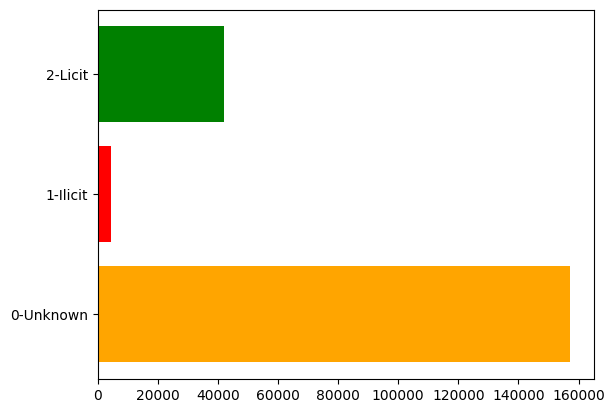

In [ ]:
group_class = df_classes.groupby('class').count()
plt.barh(['0-Unknown', '1-Ilicit', '2-Licit'], group_class['txId'].values, color=['orange', 'r', 'g'] )

<Axes: xlabel='Time step'>

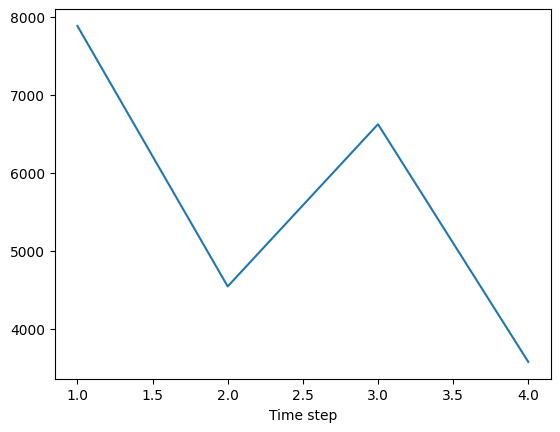

In [ ]:
group_feature = df_features.groupby('Time step').count()
group_feature['txId'].plot()
#plt.title('Number of transactions by Time step')

In [ ]:
group_class_feature = df_class_feature.groupby(['Time step', 'class']).count()
#plt.barh(['Unknown', 'Ilicit', 'Licit'], group_class['txId'].values, color=['orange', 'r', 'g'] )
group_class_feature = group_class_feature['txId'].reset_index().rename(columns={'txId': 'count'})#unstack()
group_class_feature.head()

,Time step,class,count
0,1,0,5733
1,1,1,17
2,1,2,2130
3,2,0,3427
4,2,1,18


Text(0.5, 0, 'Time step')

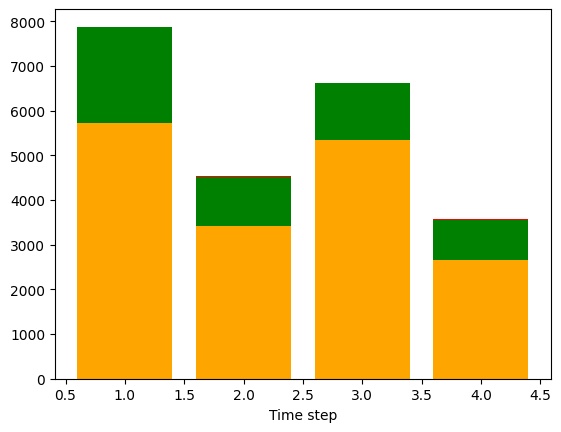

In [ ]:
class1 = group_class_feature[group_class_feature['class'] == '1']
class2 = group_class_feature[group_class_feature['class'] == '2']
class3 = group_class_feature[group_class_feature['class'] == 0 ]

p1 = plt.bar(class3['Time step'], class3['count'], color = 'orange')

p2 = plt.bar(class2['Time step'], class2['count'], color='g',
             bottom=class3['count'])

p3 = plt.bar(class1['Time step'], class1['count'], color='r',
             bottom=np.array(class3['count'])+np.array(class2['count']))

plt.xlabel('Time step')

pca.components_ (165, 165)
pca_var_ratio (165,)


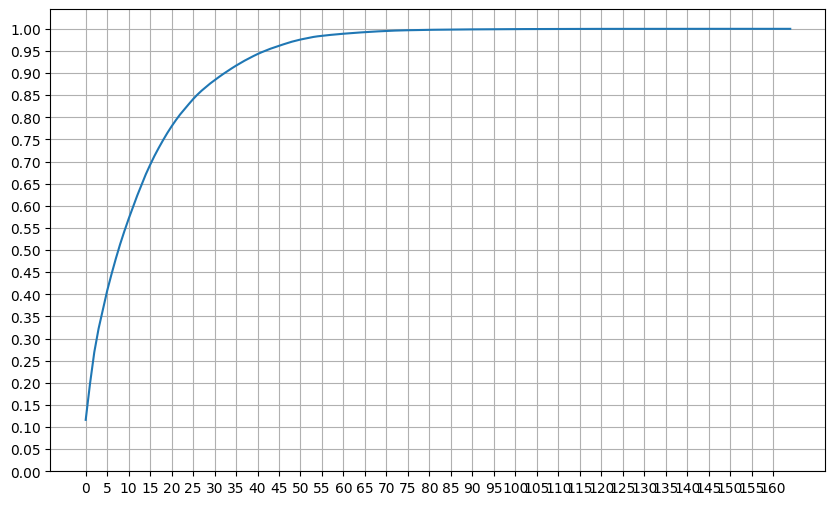

In [ ]:


# Convert non-numeric values to NaN and drop those rows
bfPCA_X = df_class_feature.drop(columns=['txId', 'Time step','class']).apply(pd.to_numeric, errors='coerce').dropna()

if __name__ == '__main__':
    y=df_class_feature['class'].values
    y = y.astype('int')
    y=y.astype(np.int32)
    pca=PCA( )
    #pca=PCA(n_components=0.9)
    pca.fit(bfPCA_X,y)
    ratio=pca.explained_variance_ratio_
    print("pca.components_",pca.components_.shape)
    print("pca_var_ratio",pca.explained_variance_ratio_.shape)

    plt.figure (figsize= (10, 6))
    plt.plot([i for i in range(bfPCA_X.shape[1])],
             [np.sum(ratio[:i+1]) for i in range(bfPCA_X.shape[1])])
    plt.xticks(np.arange(bfPCA_X.shape[1],step=5))
    plt.yticks(np.arange(0,1.01,0.05))
    plt.grid()
    plt.show()

In [ ]:
%%time
pca = PCA(n_components=0.9) #n=49
all_X = pca.fit_transform(bfPCA_X)
#print(pca.explained_variance_ratio_)

print('Data dimensions after dimension reduction：',all_X.shape)
reconMat=pca.inverse_transform(all_X)
print("Reconstructed data dimensions：",reconMat.shape)

Data dimensions after dimension reduction： (22621, 34)
Reconstructed data dimensions： (22621, 165)
CPU times: user 795 ms, sys: 124 ms, total: 919 ms
Wall time: 522 ms


In [ ]:
y = y.astype('int')
type(y)
y = y[:-1]
x_train, x_test , y_train, y_test = train_test_split(all_X, y, test_size = 0.3)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize Logistic Regression model with hyperparameters
logistic_regression_model = LogisticRegression(penalty='l2', C=1.0, class_weight='balanced', solver='liblinear')

# Train the Logistic Regression model
logistic_regression_model.fit(x_train, y_train)

# Make predictions
logistic_regression_preds = logistic_regression_model.predict(x_test)

# Evaluate the Logistic Regression model
accuracy_lr = accuracy_score(y_test, logistic_regression_preds)
precision_weighted_lr = precision_score(y_test, logistic_regression_preds, average='weighted')
recall_weighted_lr = recall_score(y_test, logistic_regression_preds, average='weighted')
f1_weighted_lr = f1_score(y_test, logistic_regression_preds, average='weighted')

# Print evaluation metrics for Logistic Regression
print("Logistic Regression:")
print("Accuracy:", accuracy_lr)
print("Weighted Avg. Precision:", precision_weighted_lr)
print("Weighted Avg. Recall:", recall_weighted_lr)
print("Weighted F1-Score:", f1_weighted_lr)


Logistic Regression:
Accuracy: 0.9006925003683512
Weighted Avg. Precision: 0.9070193517270071
Weighted Avg. Recall: 0.9006925003683512
Weighted F1-Score: 0.9017628744709953


In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Initialize Decision Tree model with hyperparameters
decision_tree_model = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=6, min_samples_leaf=3, max_features='auto')

# Train the Decision Tree model
decision_tree_model.fit(x_train, y_train)

# Make predictions
decision_tree_preds = decision_tree_model.predict(x_test)

# Evaluate the Decision Tree model
accuracy_dt = accuracy_score(y_test, decision_tree_preds)
precision_macro_dt = precision_score(y_test, decision_tree_preds, average='macro')
precision_weighted_dt = precision_score(y_test, decision_tree_preds, average='weighted')
recall_macro_dt = recall_score(y_test, decision_tree_preds, average='macro')
recall_weighted_dt = recall_score(y_test, decision_tree_preds, average='weighted')
f1_macro_dt = f1_score(y_test, decision_tree_preds, average='macro')
f1_weighted_dt = f1_score(y_test, decision_tree_preds, average='weighted')

# Print evaluation metrics for Decision Tree
print("Decision Tree:")
print("Accuracy:", accuracy_dt)
print("Weighted Avg. Precision:", precision_weighted_dt)
print("Weighted Avg. Recall:", recall_weighted_dt)
print("Weighted F1-Score:", f1_weighted_dt)


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


Decision Tree:
Accuracy: 0.8765286577280095
Weighted Avg. Precision: 0.8722145811469357
Weighted Avg. Recall: 0.8765286577280095
Weighted F1-Score: 0.8742391334851314


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest model with hyperparameters
random_forest_model = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=2, bootstrap=True)

# Train the Random Forest model
random_forest_model.fit(x_train, y_train)

# Make predictions
random_forest_preds = random_forest_model.predict(x_test)

# Evaluate the Random Forest model
accuracy_rf = accuracy_score(y_test, random_forest_preds)
precision_macro_rf = precision_score(y_test, random_forest_preds, average='macro')
precision_weighted_rf = precision_score(y_test, random_forest_preds, average='weighted')
recall_macro_rf = recall_score(y_test, random_forest_preds, average='macro')
recall_weighted_rf = recall_score(y_test, random_forest_preds, average='weighted')
f1_macro_rf = f1_score(y_test, random_forest_preds, average='macro')
f1_weighted_rf = f1_score(y_test, random_forest_preds, average='weighted')

# Print evaluation metrics for Random Forest
print("Random Forest:")
print("Accuracy:", accuracy_rf)
print("Weighted Avg. Precision:", precision_weighted_rf)
print("Weighted Avg. Recall:", recall_weighted_rf)
print("Weighted F1-Score:", f1_weighted_rf)


Random Forest:
Accuracy: 0.9254457050243112
Weighted Avg. Precision: 0.9212522545044616
Weighted Avg. Recall: 0.9254457050243112
Weighted F1-Score: 0.9224078109889938


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize Gradient Boosting model with hyperparameters
gradient_boosting_model = GradientBoostingClassifier(loss='deviance', learning_rate=0.01, n_estimators=100, criterion='friedman_mse', max_depth=3)

# Train the Gradient Boosting model
gradient_boosting_model.fit(x_train, y_train)

# Make predictions
gradient_boosting_preds = gradient_boosting_model.predict(x_test)

# Evaluate the Gradient Boosting model
accuracy_gb = accuracy_score(y_test, gradient_boosting_preds)
precision_macro_gb = precision_score(y_test, gradient_boosting_preds, average='macro')
precision_weighted_gb = precision_score(y_test, gradient_boosting_preds, average='weighted')
recall_macro_gb = recall_score(y_test, gradient_boosting_preds, average='macro')
recall_weighted_gb = recall_score(y_test, gradient_boosting_preds, average='weighted')
f1_macro_gb = f1_score(y_test, gradient_boosting_preds, average='macro')
f1_weighted_gb = f1_score(y_test, gradient_boosting_preds, average='weighted')

# Print evaluation metrics for Gradient Boosting
print("Gradient Boosting:")
print("Accuracy:", accuracy_gb)
print("Macro Avg. Precision:", precision_macro_gb)
print("Weighted Avg. Precision:", precision_weighted_gb)
print("Macro Avg. Recall:", recall_macro_gb)
print("Weighted Avg. Recall:", recall_weighted_gb)
print("Macro F1-Score:", f1_macro_gb)
print("Weighted F1-Score:", f1_weighted_gb)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


Gradient Boosting:
Accuracy: 0.8822749373802858
Macro Avg. Precision: 0.5861442391247734
Weighted Avg. Precision: 0.8788611967525745
Macro Avg. Recall: 0.5211618915580897
Weighted Avg. Recall: 0.8822749373802858
Macro F1-Score: 0.5435253873048455
Weighted F1-Score: 0.8722896787792851


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from scipy import interp

def summary(Y_test, Y_hat):
    print('accuracy',accuracy_score(Y_test,Y_hat))
    print('precision',precision_score(Y_test,Y_hat,average='macro'))
    print('recall',recall_score(Y_test,Y_hat,average='macro'))
    print('f1_score',f1_score(Y_test,Y_hat,average='macro'))

    # Calculate AUC
    encoder = LabelBinarizer()
    Y_test_onehot = encoder.fit_transform(Y_test)
    Y_hat_onehot = encoder.fit_transform(Y_hat)

    if Y_test_onehot.shape[1] == 1:  # Binary classification
        auc_score = roc_auc_score(Y_test_onehot, Y_hat_onehot)
        print('AUC', auc_score)
    else:  # Multi-class classification
        print('AUC',roc_auc_score(Y_test_onehot,Y_hat_onehot,multi_class='ovr'))

        # Compute ROC curve and ROC area for each class
        nb_classes = Y_test_onehot.shape[1]
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(nb_classes):
            fpr[i], tpr[i], _ = roc_curve(Y_test_onehot[:, i], Y_hat_onehot[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute macro-average ROC curve and ROC area

        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(nb_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(nb_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= nb_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        # Plot all ROC curves
        lw = 2
        plt.figure()

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i, color in zip(range(nb_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(i, roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.show()


In [ ]:
df_class_feature

,txId,class,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,...,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72
0,230425980,0,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,0,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,0,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,2,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,0,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22617,169452316,0,4,0.011135,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.569626,-0.607306,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
22618,11127484,0,4,0.008021,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.569626,-0.607306,-0.979074,-0.978556,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399
22619,279923887,0,4,-0.172956,-0.182478,1.018602,-0.121970,-0.063725,-0.113002,-0.061584,...,-0.577099,-0.600999,0.241128,0.241406,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
22620,87170932,0,4,-0.088987,-0.171725,-0.646376,-0.121970,0.095076,-0.113002,-0.061584,...,1.967708,1.390749,0.188625,0.047436,-0.098889,-0.010592,-0.030149,-0.087952,-0.364236,0.063698


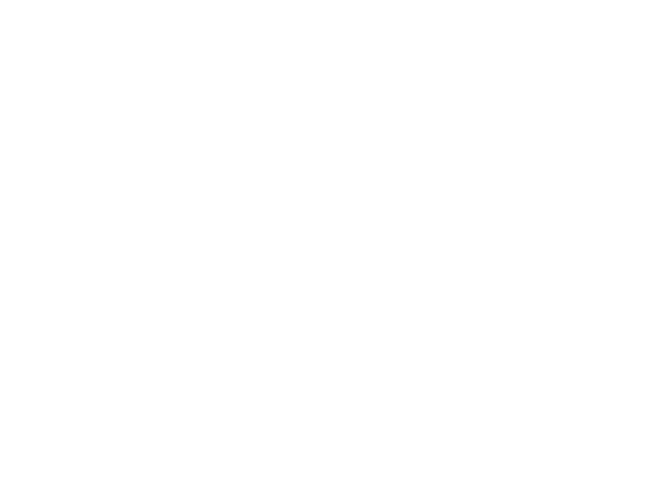

In [ ]:
ilicit_ids = df_class_feature.loc[(df_class_feature['Time step'] == 20) & (df_class_feature['class'] == '1'), 'txId']
ilicit_edges = df_edges.loc[df_edges['txId1'].isin(ilicit_ids)]

graph = nx.from_pandas_edgelist(ilicit_edges, source = 'txId1', target = 'txId2',
                                 create_using = nx.DiGraph())
pos = nx.spring_layout(graph)
nx.draw(graph, with_labels=False, pos=pos)

accuracy 0.8066892588772654
precision 0.5595800134789078
recall 0.5911529441136903
f1_score 0.4944481729382864
AUC 0.7089674898402426


<ipython-input-23-a8cb96033aaf>:42: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


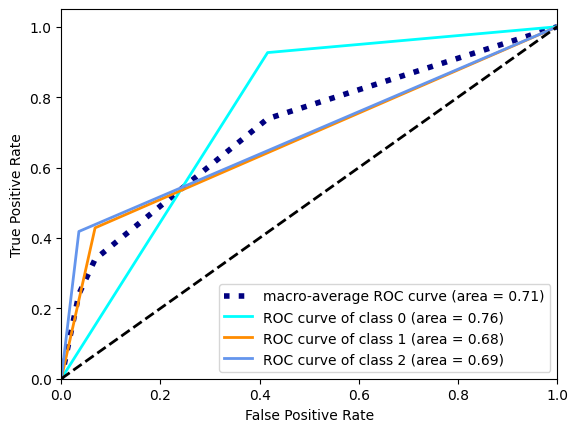

CPU times: user 397 ms, sys: 53.8 ms, total: 451 ms
Wall time: 483 ms


In [ ]:
%%time
gnb = GaussianNB().fit(x_train, y_train)
y_nb=gnb.predict(x_test)

summary(y_test,y_nb)

accuracy 0.8754972742006778
precision 0.5783874448423161
recall 0.5881100497692393
f1_score 0.5828772603821771
AUC 0.7390686767439177


<ipython-input-23-a8cb96033aaf>:42: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


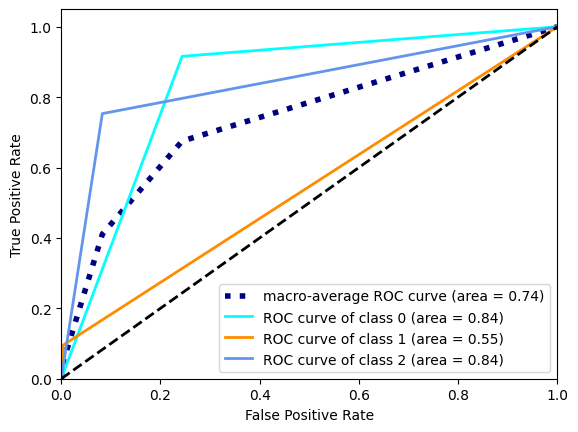

CPU times: user 2.01 s, sys: 98.7 ms, total: 2.11 s
Wall time: 2.02 s


In [ ]:
%%time
clf_cart = DecisionTreeClassifier(random_state=0, criterion="gini")
clf_cart.fit(x_train, y_train)
y_cart=clf_cart.predict(x_test)

summary(y_test,y_cart)

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.utils import to_categorical

# Assuming you've loaded your data into x_train, x_test, y_train, y_test

# Normalizing the data
mean = x_train.mean(axis=0)
std = x_train.std(axis=0)
train_x = (x_train - mean) / std
test_x = (x_test - mean) / std

# Reshape input data to have the correct number of features (21)
train_x = train_x[:, :21]  # Assuming the first 21 features are relevant
test_x = test_x[:, :21]

# Check the shape of the data
print("Shape of train_x:", train_x.shape)
print("Shape of test_x:", test_x.shape)

# One-hot encoding the labels
train_y_ohe = to_categorical(y_train, num_classes=4)
test_y_ohe = to_categorical(y_test, num_classes=4)

# Building the model
model = Sequential()

# Use Input layer instead of input_dim
model.add(Input(shape=(21,)))  # Assuming 21 features

# Hidden layers
model.add(Dense(units=16, kernel_initializer='uniform', activation='relu'))
model.add(Dense(units=16, kernel_initializer='uniform', activation='relu'))
model.add(Dense(units=8, kernel_initializer='uniform', activation='relu'))

# Adding dropout layer
model.add(Dropout(0.25))

# Output layer
model.add(Dense(4, activation='softmax'))

# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

# Training the model
model.fit(train_x, train_y_ohe, epochs=50, batch_size=4, verbose=2, validation_data=(test_x, test_y_ohe))

# Evaluating the model
loss, accuracy = model.evaluate(test_x, test_y_ohe, verbose=2)
print("loss = {}, accuracy = {}".format(loss, accuracy))

# Prediction
y_ann = model.predict(test_x, batch_size=4, verbose=2).argmax(axis=1)
print("Number of test samples: ", len(y_ann))

Shape of train_x: (15834, 21)
Shape of test_x: (6787, 21)
Epoch 1/50
3959/3959 - 11s - 3ms/step - accuracy: 0.8549 - loss: 0.4212 - val_accuracy: 0.9005 - val_loss: 0.2974
Epoch 2/50
3959/3959 - 12s - 3ms/step - accuracy: 0.8959 - loss: 0.3140 - val_accuracy: 0.9022 - val_loss: 0.2875
Epoch 3/50
3959/3959 - 7s - 2ms/step - accuracy: 0.9020 - loss: 0.2950 - val_accuracy: 0.9029 - val_loss: 0.2819
Epoch 4/50
3959/3959 - 8s - 2ms/step - accuracy: 0.9048 - loss: 0.2822 - val_accuracy: 0.9092 - val_loss: 0.2685
Epoch 5/50
3959/3959 - 8s - 2ms/step - accuracy: 0.9063 - loss: 0.2735 - val_accuracy: 0.9113 - val_loss: 0.2647
Epoch 6/50
3959/3959 - 10s - 3ms/step - accuracy: 0.9076 - loss: 0.2714 - val_accuracy: 0.9100 - val_loss: 0.2612
Epoch 7/50
3959/3959 - 9s - 2ms/step - accuracy: 0.9135 - loss: 0.2621 - val_accuracy: 0.9141 - val_loss: 0.2544
Epoch 8/50
3959/3959 - 12s - 3ms/step - accuracy: 0.9146 - loss: 0.2589 - val_accuracy: 0.9125 - val_loss: 0.2544
Epoch 9/50
3959/3959 - 10s - 2ms/s